____
__Universidad de San Andrés__<br/>
__Machine Learning__<br/>
__Estudio de data augmentation en audios de ballenas con modelos generativos__<br/>
__Martin Bianchi y Federico Gutman__
____

### Importamos las librerías necesarias

In [1]:
import os
import copy
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio, display

from src.models.classification import *
from src.models.generative import *
from src.preprocessing import *
from src.display import *
from src.metrics import *
from src.utils import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import KFold, ParameterGrid, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Definimos algunas variables globales

In [2]:
SPEC_CONFIG = {
    "SR": 2000,              # sampling rate
    "FFT_SAMPLES": 256,      # tamaño de la ventana
    "HOP_LENGTH": 63,        # salto entre frames
    "MEL_BINS": 64,          # frequency bins (resolución)
    "MAX_FREQ": 600          # máxima frecuencia para los espectrogramas
}

DATA_AUG_CONFIG = {
    'TIME_STRETCH_FACTORS': [0.9, 1.1],     # ±10%
    'PITCH_SHIFTS': [-2, 2],                # ±2 semitonos
    'NOISE_LEVEL': 0.001                    # ruido leve
}

SEED = 3    # semilla para reproducibilidad

### Cargamos los datos y los visualizamos

In [3]:
train_dir = 'data/whale-detection-challenge/data/train'
test_dir = 'data/whale-detection-challenge/data/test'
labels_dir = 'data/whale-detection-challenge/data/train.csv'

audio_df, labels_df, test_files = load_data(train_dir, test_dir, labels_dir, sampling_rate=SPEC_CONFIG['SR'])
print(audio_df.columns)

Index(['clip_name', 'label', 'filepath', 'audio'], dtype='object')


right whale call random audio sample



no right whale call random audio sample


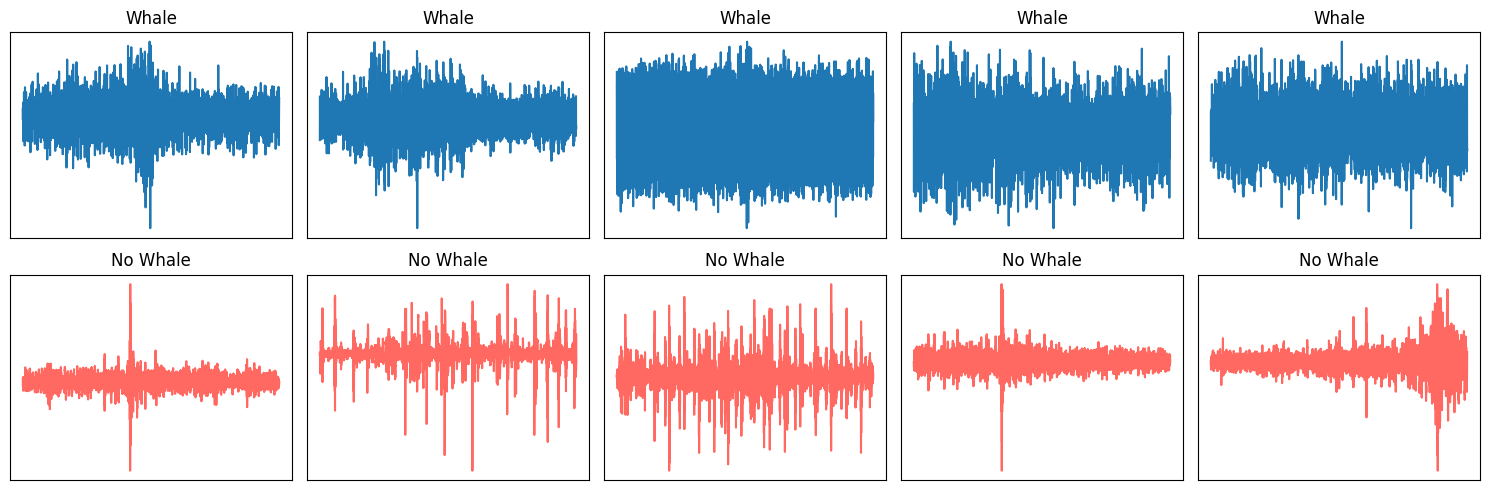

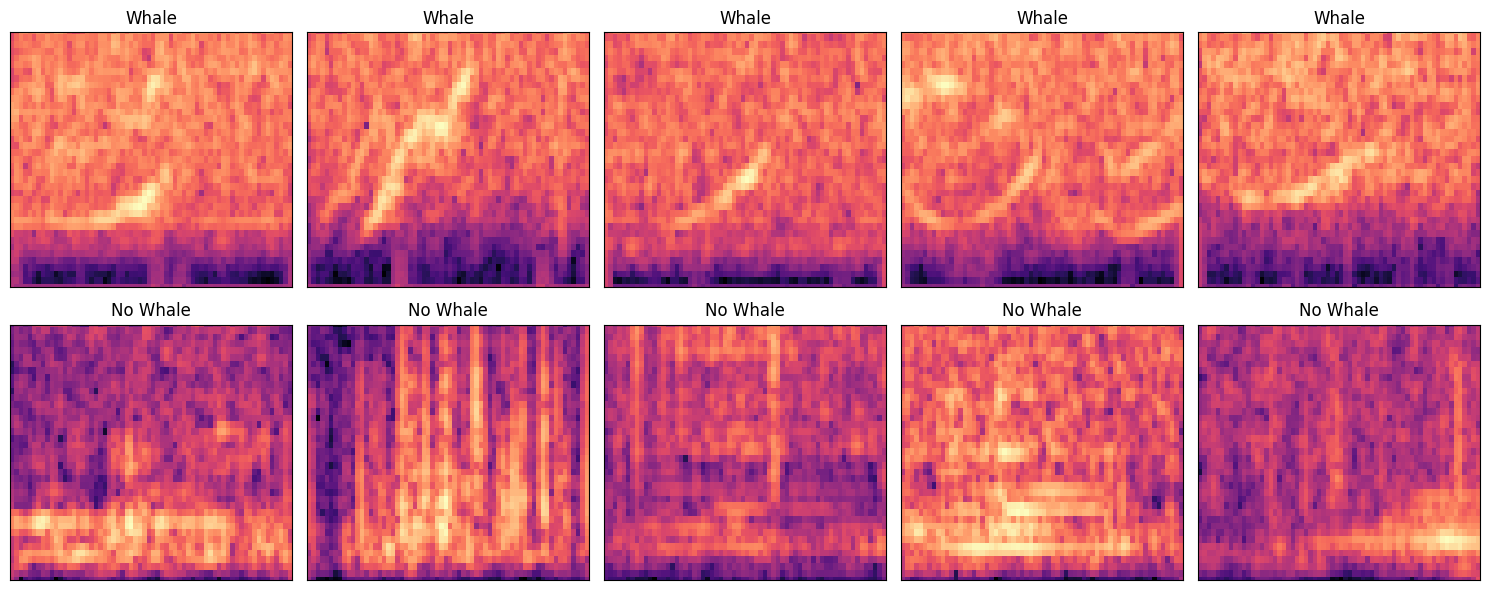

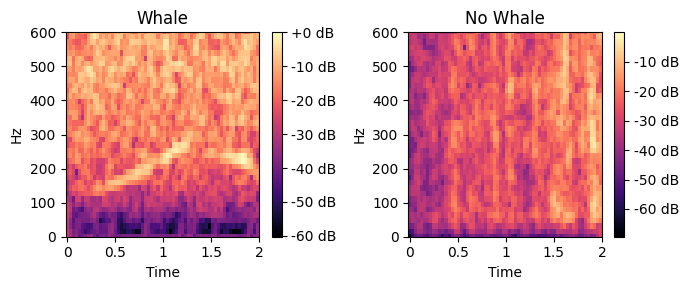

In [ ]:
normalize(audio_df, 'audio')
display_random_samples(audio_df, seed=SEED, spectrogram_config=SPEC_CONFIG)

### Hacemos un análisis exploratorio de los datos

Number of samples: 30000
Number of whale calls: 7027
Number of noise samples: 22973


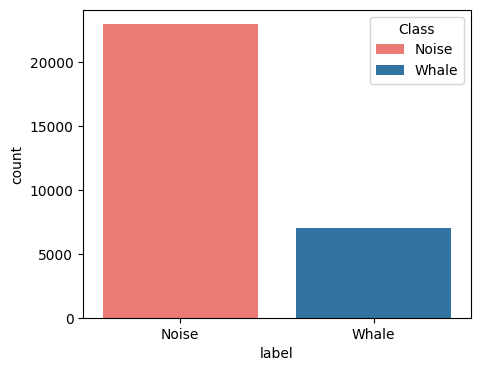

In [5]:
show_class_balance(audio_df)

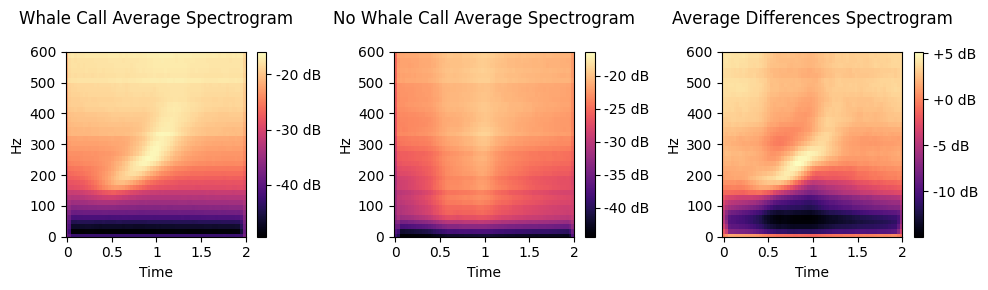

In [6]:
plot_average_spectrograms(audio_df, spectrogram_config=SPEC_CONFIG)

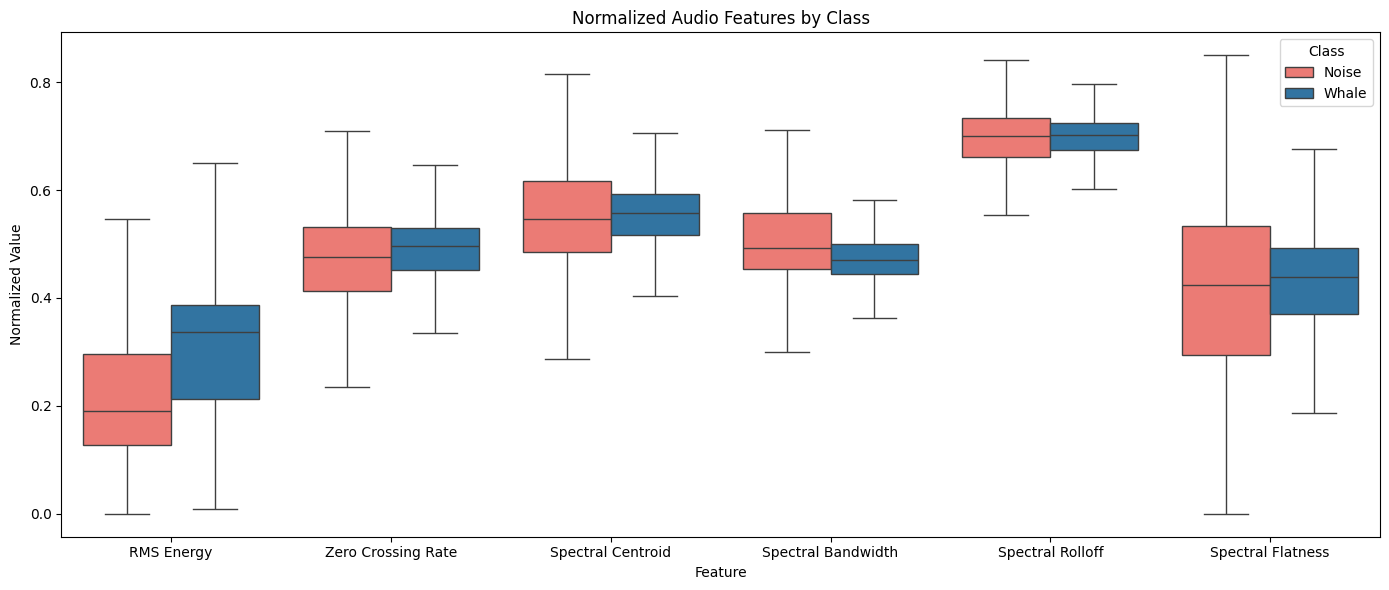

In [7]:
audio_features_df = extract_acoustic_features(audio_df)
display_features_boxplots(audio_features_df)

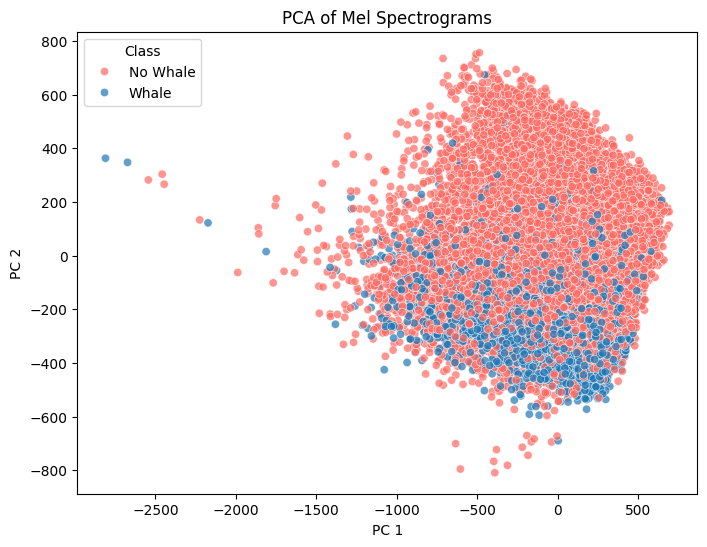

In [7]:
mel_spectrograms = get_all_mel_spectrograms(audio_df, spectrogram_config=SPEC_CONFIG)
pca = PCA(n_components=2)
spectrograms_pca = pca.fit_transform(mel_spectrograms)

plot_pca(audio_df, spectrograms_pca)

### Arrancamos el modelado

### Obtenemos los audios de entrenamiento

In [5]:
train_df, val_df = train_test_split(audio_df, test_size=0.2, random_state=SEED, stratify=audio_df['label'])

In [6]:
batch_size = 128
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print('Using device:', device)

Using device: mps


In [7]:
X_train = get_all_mel_spectrograms(train_df, SPEC_CONFIG)
y_train = train_df['label'].values
X_val = get_all_mel_spectrograms(val_df, SPEC_CONFIG)
y_val = val_df['label'].values 

In [8]:
X_train, X_val, train_mean, train_std = standarize_train_val(X_train, X_val)

Mean: -22.267026901245117, std: 10.529284487233888


### Preprocesamos los datos para entrenar los modelos

In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

### Para cada clasificador, buscamos los mejores hiperparámetros y después lo entrenamos

### Multi-Layer Perceptron (MLP)

#### Buscamos hiperparámetros

In [ ]:
hiperparams_grid = {
    'architecture': [[512, 256, 128, 64], [256, 128, 64], [128, 64]],
    'learning_rates':[1e-6, 5e-6, 1e-5, 1e-4],
    'weighted_loss': [True, False],
}

find_best_MLP_hiperparams(audio_df, hiperparams_grid, SPEC_CONFIG, epochs=50, seed=SEED)

#### Entrenamos con los hiperparámetros encontrados

Epoch 1/30 | Train Loss: 0.4722 | Val Loss: 0.4386 | Val Acc: 79.15% | Val F1: 0.6551 | Val AUC: 0.8847
Epoch 2/30 | Train Loss: 0.3882 | Val Loss: 0.3823 | Val Acc: 82.23% | Val F1: 0.6919 | Val AUC: 0.9070
Epoch 3/30 | Train Loss: 0.3531 | Val Loss: 0.3614 | Val Acc: 83.20% | Val F1: 0.7054 | Val AUC: 0.9182
Epoch 4/30 | Train Loss: 0.3322 | Val Loss: 0.3303 | Val Acc: 84.92% | Val F1: 0.7215 | Val AUC: 0.9252
Epoch 5/30 | Train Loss: 0.3174 | Val Loss: 0.3295 | Val Acc: 85.10% | Val F1: 0.7284 | Val AUC: 0.9284
Epoch 6/30 | Train Loss: 0.3074 | Val Loss: 0.3259 | Val Acc: 85.72% | Val F1: 0.7372 | Val AUC: 0.9311
Epoch 7/30 | Train Loss: 0.2982 | Val Loss: 0.3236 | Val Acc: 85.77% | Val F1: 0.7392 | Val AUC: 0.9331
Epoch 8/30 | Train Loss: 0.2907 | Val Loss: 0.3306 | Val Acc: 85.48% | Val F1: 0.7385 | Val AUC: 0.9341
Epoch 9/30 | Train Loss: 0.2841 | Val Loss: 0.2998 | Val Acc: 86.75% | Val F1: 0.7487 | Val AUC: 0.9360
Epoch 10/30 | Train Loss: 0.2784 | Val Loss: 0.3011 | Val Acc: 8

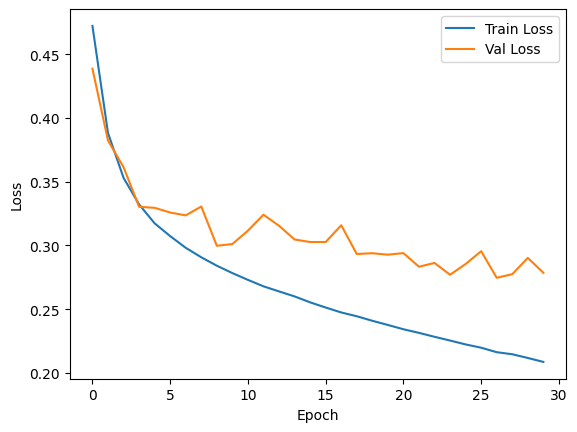

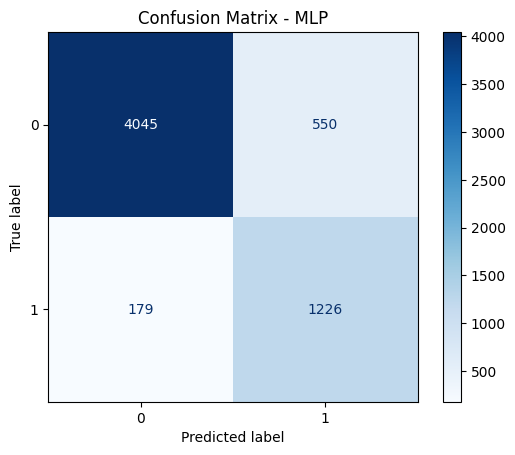

In [59]:
mlp_torch = MLP(X_train.shape[1]).to(device)
train_losses, val_losses = mlp_torch.train_model(train_loader, val_loader, epochs=30, lr=5e-6, use_class_weights=True)

mlp_torch.evaluate(val_loader)
mlp_torch.plot_learning_curves()
mlp_torch.confusion_matrix(val_loader)

### Pasamos los tensores a numpy

In [ ]:
X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy()
X_val_np = X_val_tensor.numpy()
y_val_np = y_val_tensor.numpy()

In [ ]:
X_combined = np.concatenate([X_train_np, X_val_np], axis=0)
y_combined = np.concatenate([y_train_np, y_val_np], axis=0)

### Random Forest

#### Buscamos hiperparámetros

In [ ]:
hiperparams_grid = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth':[40, 50, 60, 70],
    'weighted_loss': [True, False],
}

find_best_ensemble_hiperparams(RandomForestClassifier, X_combined, y_combined, hiperparams_grid, seed=SEED) # esto hay que hacerlo sobre train + val, no solo con los train que separe arriba
# correr y chequear si funca

#### Entrenamos con los hiperparámetros encontrados

Validation Accuracy (Random Forest): 0.8705
Validation F1-Score (Random Forest): 0.6863
Validation ROC-AUC (Random Forest): 0.7783


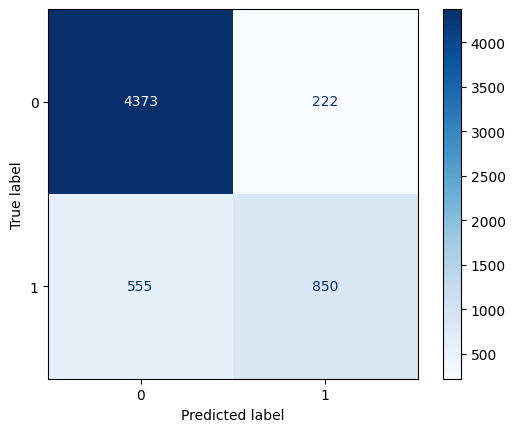

In [61]:
rf_model = train_random_forest(X_train_np, y_train_np, X_val_np, y_val_np)
show_confusion_matrix(rf_model, X_val_np, y_val_np)

### Gradient Boosting

#### Buscamos hiperparámetros

In [ ]:
hiperparams_grid = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth':[40, 50, 60, 70],
}

find_best_ensemble_hiperparams(GradientBoostingClassifier, X_combined, y_combined, hiperparams_grid, seed=SEED)

#### Entrenamos con los hiperparámetros encontrados

Validation Accuracy (Gradient Boosting): 0.8733
Validation F1-Score (Gradient Boosting): 0.7081
Validation ROC-AUC (Gradient Boosting): 0.7980


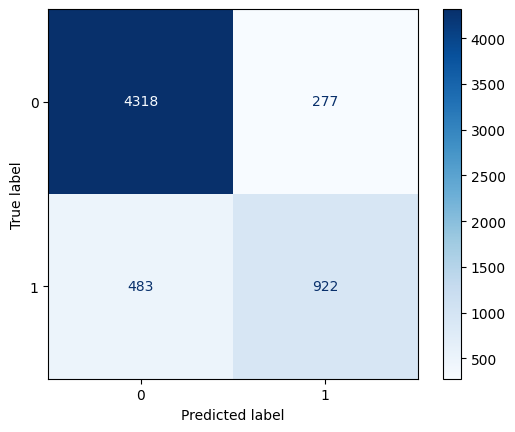

In [62]:
gb_model = train_gradient_boosting(X_train_np, y_train_np, X_val_np, y_val_np)
show_confusion_matrix(gb_model, X_val_np, y_val_np)

### MLP convolucional

#### Preparamos los espectrogramas para poder aplicarles convoluciones

In [ ]:
train_mel_spec = []
for whale_audio in train_df['audio']:
    mel = get_melspectrogram(whale_audio, SPEC_CONFIG['SR'], SPEC_CONFIG['FFT_SAMPLES'], SPEC_CONFIG['HOP_LENGTH'], SPEC_CONFIG['MEL_BINS'], SPEC_CONFIG['MAX_FREQ']) # shape: (64, 64)
    mel = mel[np.newaxis, :, :] # shape: (1, 64, 64)
    train_mel_spec.append(mel)

val_mel_spec = []
for whale_audio in val_df['audio']:
    mel = get_melspectrogram(whale_audio, SPEC_CONFIG['SR'], SPEC_CONFIG['FFT_SAMPLES'], SPEC_CONFIG['HOP_LENGTH'], SPEC_CONFIG['MEL_BINS'], SPEC_CONFIG['MAX_FREQ']) # shape: (64, 64)
    mel = mel[np.newaxis, :, :] # shape: (1, 64, 64)
    val_mel_spec.append(mel)

In [64]:
X_train_CNN = np.array(train_mel_spec)
X_val_CNN = np.array(val_mel_spec)

y_train_CNN = train_df['label'].values
y_val_CNN = val_df['label'].values

In [ ]:
X_combined_CNN = np.concatenate([X_train_CNN, X_val_CNN])
y_combined_CNN = np.concatenate([y_train_CNN, y_val_CNN], axis=0)

In [65]:
X_train_CNN, X_val_CNN, train_mean_CNN, train_std_CNN = standarize_train_val(X_train_CNN, X_val_CNN)

Mean: -22.267026901245117, std: 10.529284487233888


In [66]:
X_train_tensor_CNN = torch.tensor(X_train_CNN, dtype=torch.float32)
y_train_tensor_CNN = torch.tensor(y_train_CNN, dtype=torch.long)
X_val_tensor_CNN = torch.tensor(X_val_CNN, dtype=torch.float32)
y_val_tensor_CNN = torch.tensor(y_val_CNN, dtype=torch.long)

train_loader_CNN = DataLoader(TensorDataset(X_train_tensor_CNN, y_train_tensor_CNN), batch_size=batch_size, shuffle=True)
val_loader_CNN = DataLoader(TensorDataset(X_val_tensor_CNN, y_val_tensor_CNN), batch_size=batch_size)

#### Buscamos hiperparámetros

In [ ]:
hiperparams_grid = {
    'learning_rates':[1e-5, 1e-4, 1e-3, 1e-2],
    'weighted_loss': [True, False],
}

find_best_CNN_hiperparams(X_combined_CNN, y_combined_CNN, hiperparams_grid, epochs=50, seed=SEED)

#### Entrenamos con los hiperparámetros encontrados

Epoch 1/50 | Train Loss: 0.3107 | Val Loss: 0.2507 | Val Acc: 89.57% | Val F1: 0.7605 | Val AUC: 0.9595
Epoch 2/50 | Train Loss: 0.2341 | Val Loss: 0.2229 | Val Acc: 91.05% | Val F1: 0.8178 | Val AUC: 0.9659
Epoch 3/50 | Train Loss: 0.2090 | Val Loss: 0.2090 | Val Acc: 91.98% | Val F1: 0.8232 | Val AUC: 0.9718
Epoch 4/50 | Train Loss: 0.1892 | Val Loss: 0.2008 | Val Acc: 91.43% | Val F1: 0.8367 | Val AUC: 0.9703
Epoch 5/50 | Train Loss: 0.1671 | Val Loss: 0.1846 | Val Acc: 92.23% | Val F1: 0.8336 | Val AUC: 0.9738
Epoch 6/50 | Train Loss: 0.1481 | Val Loss: 0.1730 | Val Acc: 92.83% | Val F1: 0.8524 | Val AUC: 0.9761
Epoch 7/50 | Train Loss: 0.1374 | Val Loss: 0.1788 | Val Acc: 92.77% | Val F1: 0.8507 | Val AUC: 0.9751
Epoch 8/50 | Train Loss: 0.1238 | Val Loss: 0.1837 | Val Acc: 92.55% | Val F1: 0.8495 | Val AUC: 0.9746
Epoch 9/50 | Train Loss: 0.1094 | Val Loss: 0.1932 | Val Acc: 92.77% | Val F1: 0.8485 | Val AUC: 0.9749
Epoch 10/50 | Train Loss: 0.0935 | Val Loss: 0.2173 | Val Acc: 9

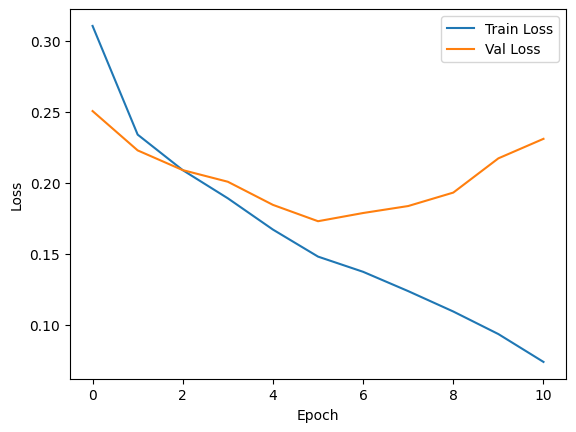

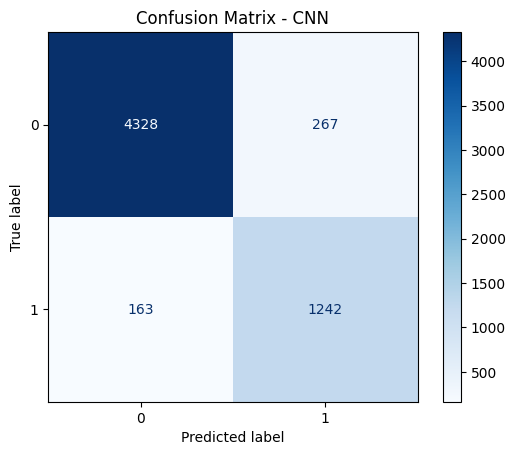

In [ ]:
cnn_model = ConvolutionalMLP()
cnn_model.train_model(train_loader_CNN, val_loader_CNN, epochs=15, early_stopping_patience=5, use_class_weights=False)

cnn_model.evaluate(val_loader_CNN)
cnn_model.plot_learning_curves()
cnn_model.confusion_matrix(val_loader_CNN)

### Visualizamos las curvas ROC de los modelos

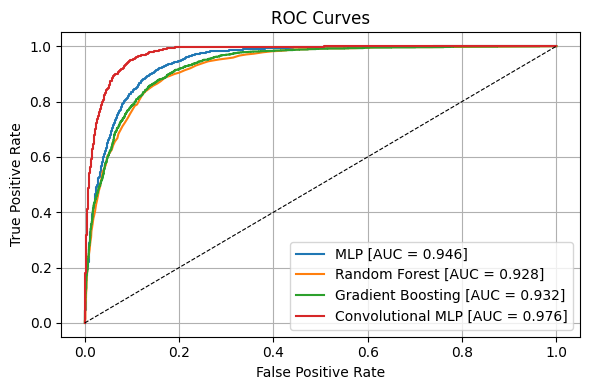

In [ ]:
models = {
    'MLP': mlp_torch,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Convolutional MLP': cnn_model
}

plot_roc_curves(models, val_loader, val_loader_CNN, X_val_np, y_val_np)

### Entrenamos un VAE con todas las muestras y analizamos el espacio latente

Epoch [1], Loss: 39592114.70, Recon: 37875049.12, KL: 572355.18
Epoch [2], Loss: 26403669.41, Recon: 24451236.14, KL: 650811.08
Epoch [3], Loss: 24716204.56, Recon: 22557191.27, KL: 719671.09
Epoch [4], Loss: 23966593.38, Recon: 21713554.37, KL: 751013.00
Epoch [5], Loss: 23669738.12, Recon: 21386466.59, KL: 761090.50
Epoch [6], Loss: 23323305.11, Recon: 20994014.21, KL: 776430.30
Epoch [7], Loss: 23077133.69, Recon: 20683402.00, KL: 797910.55
Epoch [8], Loss: 22809534.21, Recon: 20383463.42, KL: 808690.26
Epoch [9], Loss: 22744546.34, Recon: 20294338.71, KL: 816735.88
Epoch [10], Loss: 22574059.25, Recon: 20106312.55, KL: 822582.23
Epoch [11], Loss: 22474243.36, Recon: 19999313.65, KL: 824976.57
Epoch [12], Loss: 22332438.28, Recon: 19846006.92, KL: 828810.43
Epoch [13], Loss: 22321872.30, Recon: 19835899.91, KL: 828657.47
Epoch [14], Loss: 22204715.82, Recon: 19709961.15, KL: 831584.88
Epoch [15], Loss: 22083971.32, Recon: 19584172.23, KL: 833266.37
Epoch [16], Loss: 22060035.17, Rec

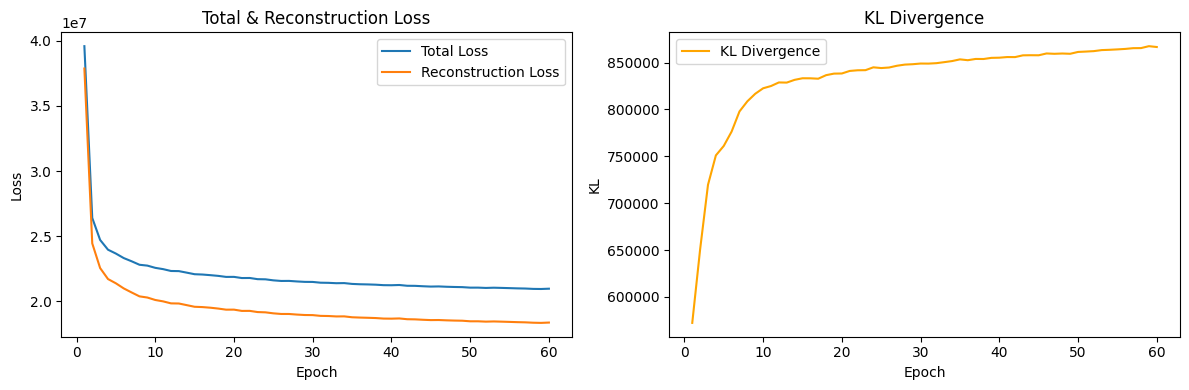

In [74]:
full_beta_vae = train_vae(train_loader_CNN, latent_dimension=32, beta=3.0, epochs=60)

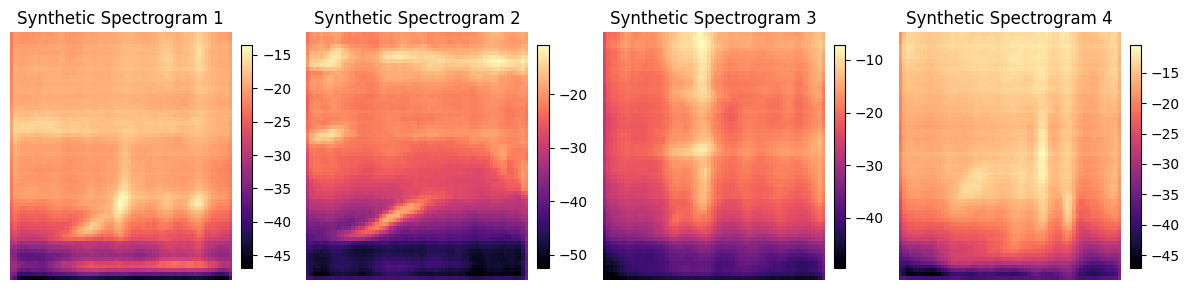

In [182]:
display_vae_synthetic_samples(full_beta_vae, train_mean, train_std, SPEC_CONFIG)

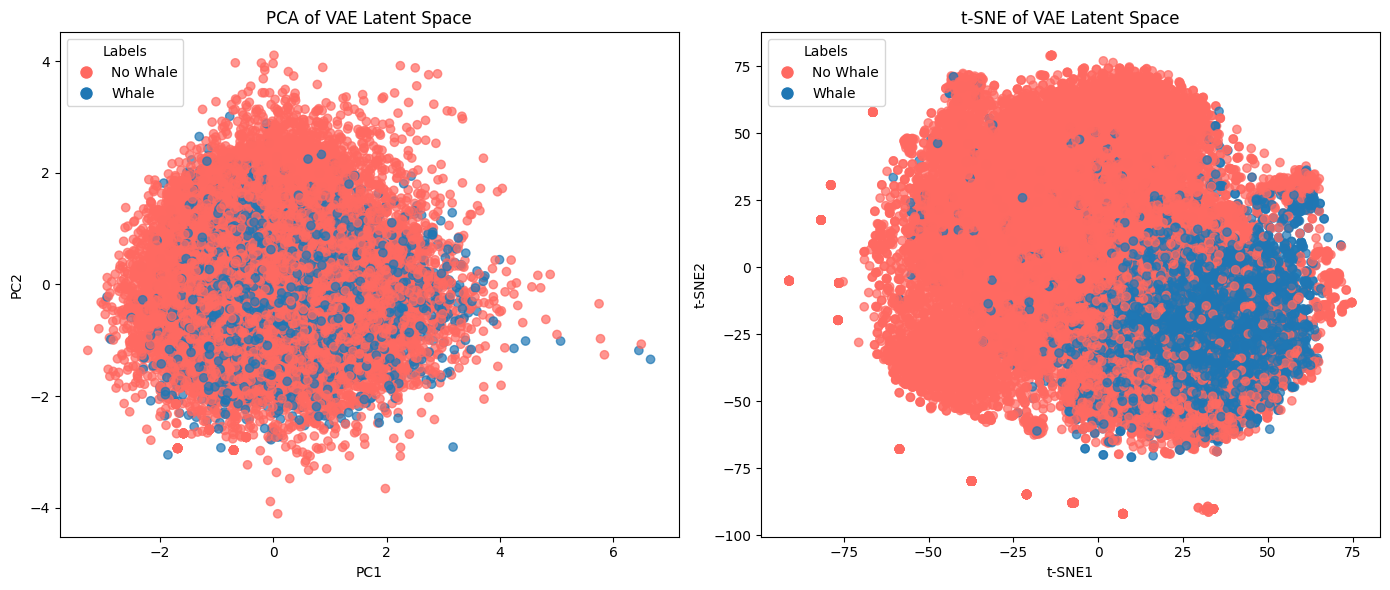

In [ ]:
display_full_vae_latent_space(full_beta_vae, train_loader_CNN, device, seed=SEED)

### Arrancamos con el entrenamiento de los modelos generativos

#### Obtenemos los espectrogramas de todos los cantos de ballena y los estandarizamos

In [ ]:
whale_audios = train_df[train_df['label'] == 1] # obtenemos solo los audios con cantos de ballena

In [11]:
mel_specs = []
for whale_audio in whale_audios['audio']:
    mel = get_melspectrogram(whale_audio, SPEC_CONFIG['SR'], SPEC_CONFIG['FFT_SAMPLES'], SPEC_CONFIG['HOP_LENGTH'], SPEC_CONFIG['MEL_BINS'], SPEC_CONFIG['MAX_FREQ']) # shape: (64, 64)
    mel = mel[np.newaxis, :, :] # shape: (1, 64, 64)
    mel_specs.append(mel)

In [12]:
gen_train = np.array(mel_specs)
gen_train, gen_train_mean, gen_train_std = standarize_train(gen_train)

Mean: -21.889528274536133, std: 11.347515116201173


In [13]:
gen_train_tensor = torch.tensor(gen_train, dtype=torch.float32)
gen_loader = DataLoader(TensorDataset(gen_train_tensor), batch_size=batch_size, shuffle=True)

#### Variational Autoencoder (VAE)

Epoch [1], Loss: 13496425.31, Recon: 13219339.34, KL: 92361.98
Epoch [2], Loss: 6001551.34, Recon: 5619263.69, KL: 127429.22
Epoch [3], Loss: 5474552.70, Recon: 5120155.17, KL: 118132.52
Epoch [4], Loss: 5234280.31, Recon: 4935983.87, KL: 99432.15
Epoch [5], Loss: 5100546.19, Recon: 4838351.34, KL: 87398.28
Epoch [6], Loss: 4923496.16, Recon: 4673074.82, KL: 83473.79
Epoch [7], Loss: 4878524.95, Recon: 4631649.38, KL: 82291.86
Epoch [8], Loss: 4761343.41, Recon: 4506831.85, KL: 84837.18
Epoch [9], Loss: 4709426.09, Recon: 4442570.37, KL: 88951.91
Epoch [10], Loss: 4606395.37, Recon: 4320223.00, KL: 95390.79
Epoch [11], Loss: 4519055.23, Recon: 4220006.60, KL: 99682.88
Epoch [12], Loss: 4473207.88, Recon: 4161724.79, KL: 103827.70
Epoch [13], Loss: 4463396.05, Recon: 4142481.65, KL: 106971.47
Epoch [14], Loss: 4419046.34, Recon: 4088083.73, KL: 110320.87
Epoch [15], Loss: 4361008.38, Recon: 4023265.69, KL: 112580.90
Epoch [16], Loss: 4357755.78, Recon: 4012516.45, KL: 115079.78
Epoch [1

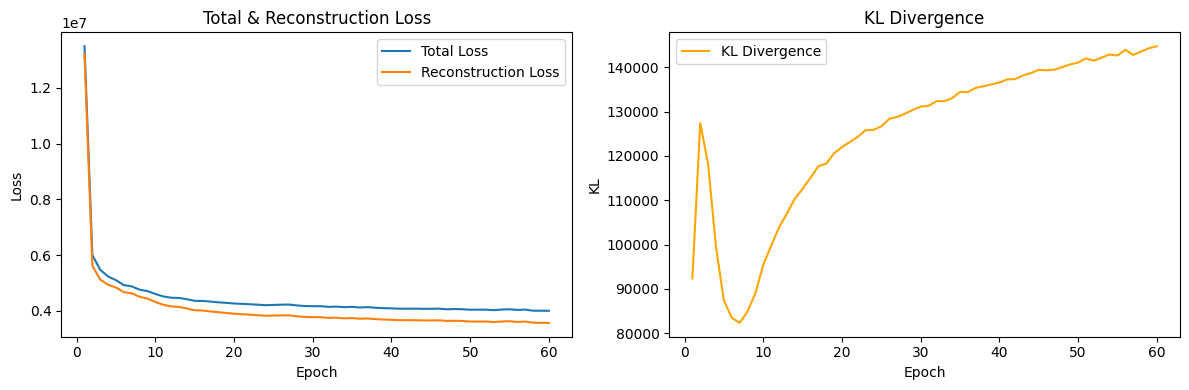

[✔] Modelo guardado en: saved_models/bvae.pt


In [ ]:
beta_vae = train_vae(train_loader_CNN, latent_dimension=32, beta=3.0, epochs=60)
save_model(beta_vae, path='saved_models/bvae.pt')

In [15]:
beta_vae = load_model(path='saved_models/bvae.pt')

[✔] Modelo cargado desde: saved_models/bvae.pt


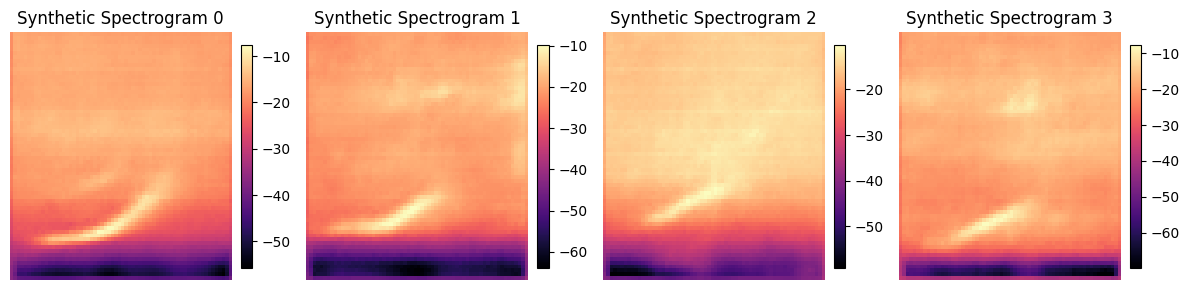

In [ ]:
display_vae_synthetic_samples(beta_vae, train_mean_CNN, train_std_CNN, SPEC_CONFIG)

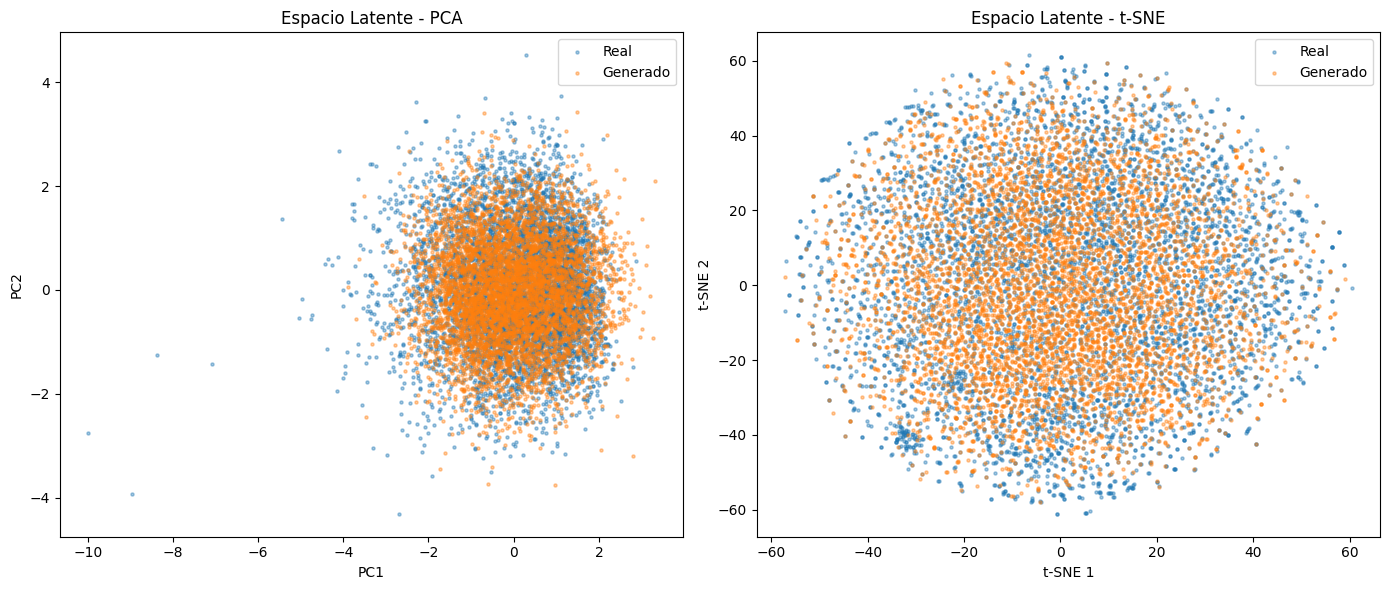

In [ ]:
plot_bvae_latent_comparison(beta_vae, gen_loader, device)

#### Adversarial Autoencoder (AAE)

In [147]:
encoder, decoder, discriminator = train_aae(gen_loader, device)
save_aae_models(encoder, decoder, discriminator)

Epoch [0] Recon: 12376358.23, Disc: 3833.51, Gen: 17927.58
Epoch [1] Recon: 5362214.25, Disc: 520.28, Gen: 35555.50
Epoch [2] Recon: 4894683.19, Disc: 232.07, Gen: 37930.37
Epoch [3] Recon: 4767428.02, Disc: 199.06, Gen: 37463.13
Epoch [4] Recon: 4645100.09, Disc: 169.31, Gen: 38409.34
Epoch [5] Recon: 4586896.85, Disc: 139.05, Gen: 37265.60
Epoch [6] Recon: 5409364.60, Disc: 168.03, Gen: 51185.85
Epoch [7] Recon: 4457335.32, Disc: 166.89, Gen: 44697.06
Epoch [8] Recon: 4354865.41, Disc: 204.86, Gen: 44349.53
Epoch [9] Recon: 4276328.09, Disc: 146.58, Gen: 38057.96
Epoch [10] Recon: 4158220.09, Disc: 134.24, Gen: 37980.72
Epoch [11] Recon: 4312745.04, Disc: 206.20, Gen: 43292.51
Epoch [12] Recon: 3977443.69, Disc: 315.64, Gen: 46172.90
Epoch [13] Recon: 3897659.74, Disc: 629.18, Gen: 44376.10
Epoch [14] Recon: 3881503.02, Disc: 730.11, Gen: 43413.00
Epoch [15] Recon: 3814135.78, Disc: 482.73, Gen: 39831.62
Epoch [16] Recon: 3781394.62, Disc: 627.86, Gen: 37969.97
Epoch [17] Recon: 3736

In [42]:
latent_dimensions = 32
encoder, decoder, discriminator = load_aae_models(latent_dim=latent_dimensions)

[✔] AAE cargado desde: saved_models/aae


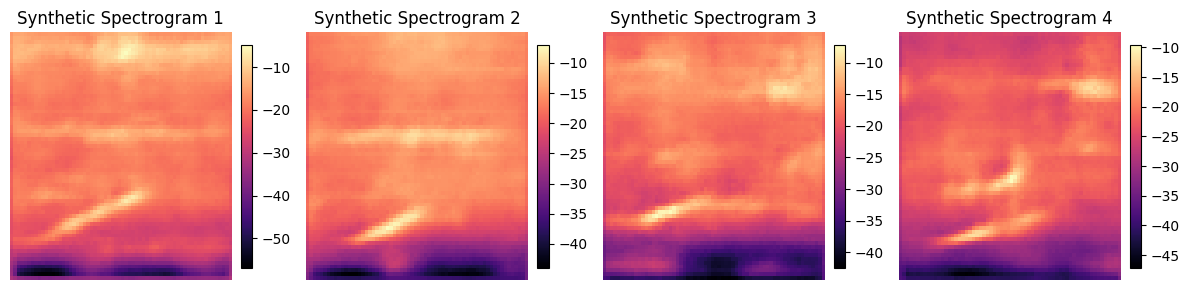

In [ ]:
display_aae_synthetic_samples(decoder, latent_dimensions, train_mean_CNN, train_std_CNN, SPEC_CONFIG)

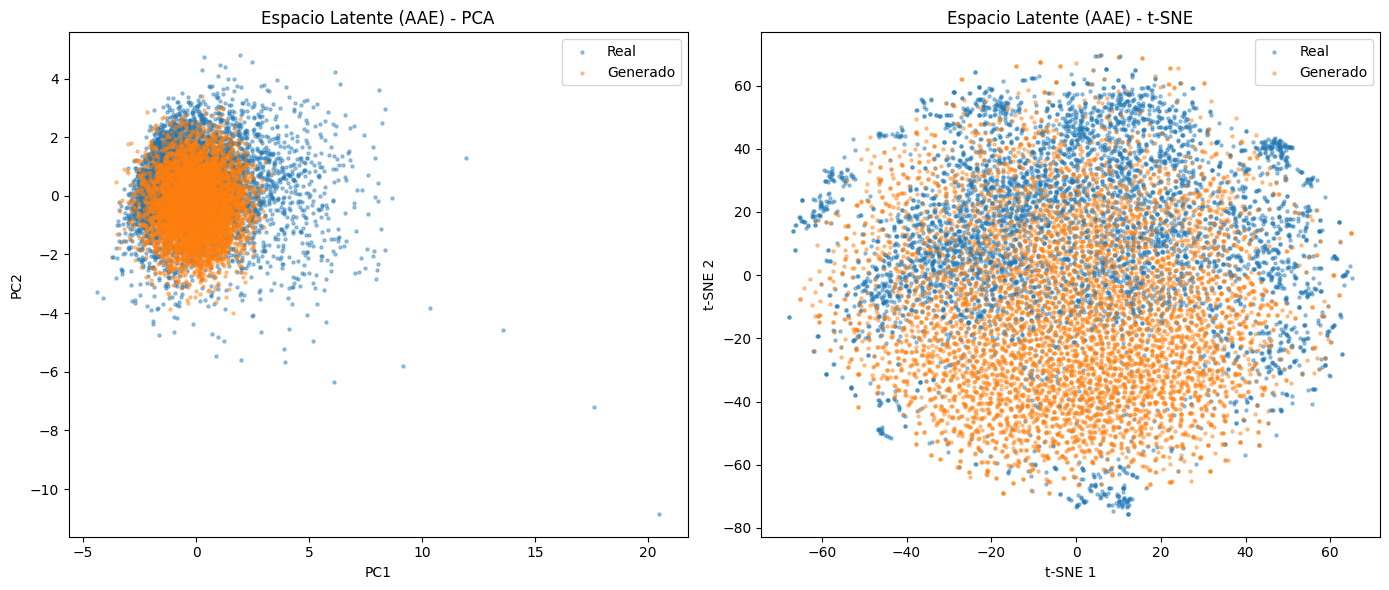

In [45]:
plot_aae_latent_comparison(encoder, decoder, gen_loader, device)

#### Generative Adversarial Network (GAN)

In [59]:
X_GAN = np.array(mel_specs, dtype=np.float32)
low, high = np.percentile(X_GAN, [5, 95])
X_GAN = robust_normalize(X_GAN, low, high)

X_tensor_GAN = torch.tensor(X_GAN, dtype=torch.float32)
train_loader_GAN = DataLoader(TensorDataset(X_tensor_GAN), batch_size=batch_size, shuffle=True)

low -44.76902141571045
high -7.858511042594914


In [ ]:
train_gan(train_loader_GAN)

In [52]:
gan_generator, gan_discriminator = load_gan_models(device, path_disc='saved_models/specgan/discriminator_epoch_200.pt', path_gen='saved_models/specgan/generator_epoch_200.pt')

[✔] Modelos cargados desde:
  - saved_models/specgan/generator_epoch_200.pt
  - saved_models/specgan/discriminator_epoch_200.pt


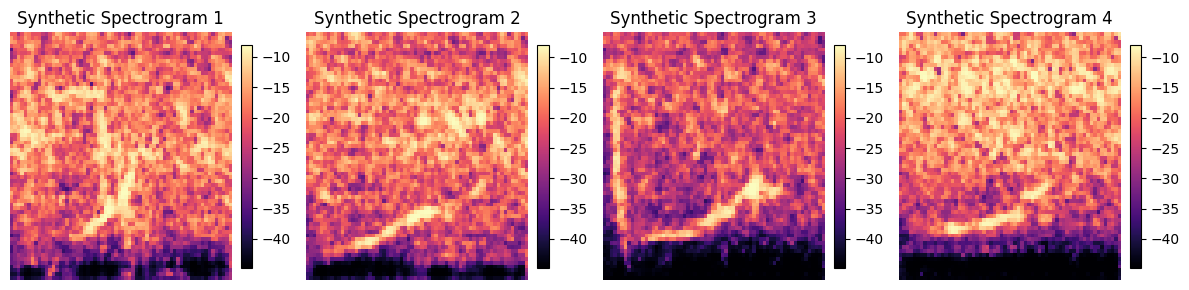

In [ ]:
display_gan_synthetic_samples(gan_generator, 100, low, high, SPEC_CONFIG)

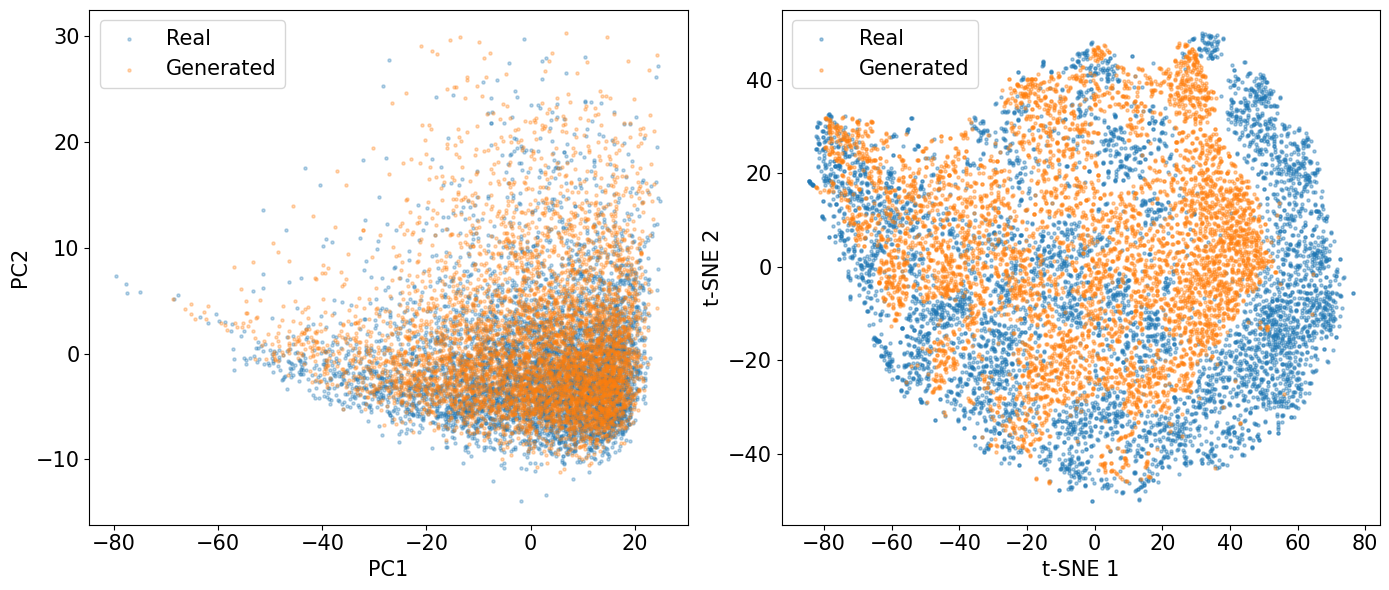

In [81]:
plot_specgan_output_projection_full(gan_generator, train_loader_GAN, device='mps')